(315, 550, 550, 3) (315, 15)
Epoch 1/100


2023-10-24 22:10:26.755958: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-24 22:10:30.003424: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.94GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-24 22:10:43.212303: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5868014e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-24 22:10:43.212341: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-10-24 22:10:43.217232: I tensorflow/compi

Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Test loss: 0.2857435345649719
Test accuracy: 0.920634925365448
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 550, 550, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 550, 550, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 550, 550, 64)      36928     
           

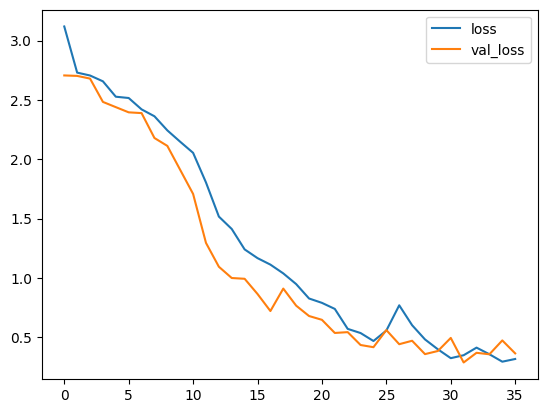

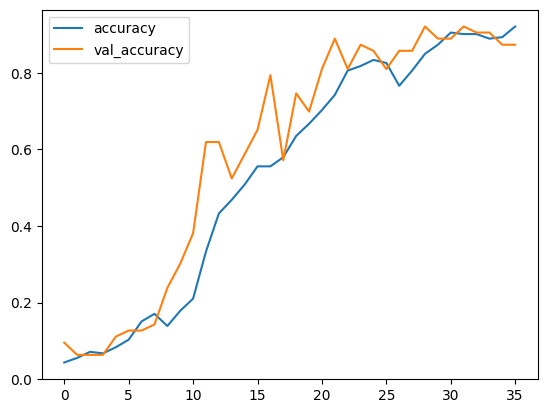

In [2]:
# 画像の読み込み
# $bash copy_image.sh　実行後のディレクトリ構成
# ref: https://qiita.com/ba--shi/items/09f5f2f119ffbd9bb316
import os
import cv2 # dockerの場合　$apt install libgl1-mesa-dev
import matplotlib.pyplot as plt

def modify_image(img, width, height):
    """指定した大きさに収まるように、アスペクト比を固定して、リサイズする。
       ref: https://camp.trainocate.co.jp/magazine/python-opencv/
    """
    h, w = img.shape[:2]
    aspect = w / h
    if width / height >= aspect:
        nh = height
        nw = round(nh * aspect)
    else:
        nw = width
        nh = round(nw / aspect)

    scaled = cv2.resize(img, dsize=(nw, nh))
    h_padding = round((height - nh) / 2)
    w_padding = round((width - nw) / 2)
    dst = cv2.copyMakeBorder(scaled, h_padding, height - nh - h_padding, w_padding, width- nw - w_padding, cv2.BORDER_REPLICATE)

    return dst

image_list = []
label_list = []
IMAGE_SIZE = 550
BASE_DIR = os.getcwd()

for dir in os.listdir(BASE_DIR + "/images"):
    img_dir =  BASE_DIR + "/images/" + dir
    # フォルダごとにラベル分けする
    label = dir

    for file in os.listdir(img_dir):
        # 配列label_listに正解ラベルを追加
        label_list.append(label)

        # 配列image_listに画像の配列データを追加
        filepath = img_dir + "/" + file
        img = cv2.imread(filepath)
        image = modify_image(img, IMAGE_SIZE, IMAGE_SIZE)
        # cv2.imwrite(f'modifyed/{file}', image)
        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.show()
        # image = img_to_array(img)
        image_list.append(image)



import tensorflow as tf
import numpy as np

X = np.asarray(image_list).astype('float32') / 255.0

N_CLASSES = 15
Y = np.asarray(label_list)
Y = tf.keras.utils.to_categorical(Y, N_CLASSES)

print(X.shape, Y.shape)

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)


BATCH_SIZE = 32

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255,
    zoom_range=0.2,
    rotation_range=45,
    height_shift_range=0.1,
    width_shift_range=0.1,
    channel_shift_range=0.1,
)
train_generator = data_generator.flow(train_x, train_y, batch_size=BATCH_SIZE, shuffle=True)

def show_imgs(imgs, row, col):
    for i, img in enumerate(imgs):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plot_num = i+1
        plt.subplot(row, col, plot_num)
        plt.tick_params(labelbottom=False)
        plt.tick_params(labelleft=False)
        plt.imshow(img)
    plt.show()

# for i in range(3):
#     data = next(train_generator)
#     show_imgs(data[0], 4, 4)


callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=4,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'data/temp/road_sign_sequential_{epoch:03d}_{val_loss:.4f}.h5',
        save_best_only=True
    ),
    # tf.keras.callbacks.TensorBoard(
    #     log_dir='logs',
    #     histogram_freq=1
    # ),
]



from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
for layer in vgg_model.layers:
    layer.trainable = False

x = vgg_model.output
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
# x = Dropout(0.3)(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(N_CLASSES, activation='softmax')(x)

EPOCHS = 100

model = tf.keras.Model(inputs=vgg_model.input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose='1', validation_data=(test_x, test_y), callbacks=callbacks)
# history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose='1', validation_data=(test_x, test_y), callbacks=callbacks)
model.save('model.keras')



score = model.evaluate(test_x, test_y, verbose='0')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# !tensorboard --logdir logs/fit



import pandas as pd

hist_df = pd.DataFrame(history.history)
hist_df[['loss', 'val_loss']].plot()
hist_df[['accuracy', 'val_accuracy']].plot()

print(model.summary())





In [4]:

image_list = []
label_list = []

for dir in os.listdir(BASE_DIR + "/Test_images"):
    img_dir =  BASE_DIR + "/Test_images/" + dir
    # フォルダごとにラベル分けする
    label = dir

    for file in os.listdir(img_dir):
        # 配列label_listに正解ラベルを追加
        label_list.append(label)

        # 配列image_listに画像の配列データを追加
        filepath = img_dir + "/" + file
        img = cv2.imread(filepath)
        image = modify_image(img, IMAGE_SIZE, IMAGE_SIZE)
        # cv2.imwrite(f'modifyed/{file}', image)
        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.show()
        # image = img_to_array(img)
        image_list.append(image)


X = np.asarray(image_list).astype('float32') / 255.0

N_CLASSES = 15
Y = np.asarray(label_list)
Y = tf.keras.utils.to_categorical(Y, N_CLASSES)

score = model.evaluate(X, Y, verbose='1')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

: 

0.5024752616882324
0.5668317079544067
0.5891088843345642